In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import os

# Base path
base_path = '/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/'

# Load dev and test CSVs
train_df = pd.read_csv(os.path.join(base_path, 'train/train_sent_emo.csv'))
 # treating dev as train
test_df = pd.read_csv(os.path.join(base_path, 'test_sent_emo.csv'))

print(f"Train Shape (using dev_sent_emo.csv): {train_df.shape}")
print(f"Test Shape: {test_df.shape}")

# Preview the first few rows
train_df.head()


Train Shape (using dev_sent_emo.csv): (9989, 11)
Test Shape: (2610, 11)


,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [3]:
import pandas as pd

# Correct loading:
dev_df = pd.read_csv('/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/dev_sent_emo.csv')
test_df = pd.read_csv('/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/test_sent_emo.csv')

# Use dev_df for training
X = dev_df['Utterance']
y = dev_df['Emotion']

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters
max_vocab_size = 10000  # Max number of words to keep
max_seq_len = 50        # Max sentence length (after checking data)

# Tokenizer
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_seq_len, padding='post')


2025-05-10 19:10:54.333441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746904254.368128  270808 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746904254.377884  270808 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set maximum number of words
vocab_size = 10000  # or higher depending on your dataset

# Set maximum length of a sentence
max_len = 50  

# 1. Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

# 2. Convert text to sequences
X_seq = tokenizer.texts_to_sequences(X)

# 3. Pad the sequences
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post', truncating='post')

print("Shape of padded input:", X_pad.shape)


Shape of padded input: (1109, 50)


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, GRU, Dense, Dropout, Concatenate

# Input layer
input_text = Input(shape=(max_len,))

# Embedding layer
embedding = Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len)(input_text)

# CNN layer
cnn = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding)
pool = MaxPooling1D(pool_size=2)(cnn)

# BiLSTM layer
bilstm = Bidirectional(LSTM(64, return_sequences=True))(pool)

# GRU layer
gru = GRU(64)(bilstm)

# Fully connected layers
dense1 = Dense(64, activation='relu')(gru)
dropout = Dropout(0.5)(dense1)
output = Dense(len(y.unique()), activation='softmax')(dropout)

# Model
model = Model(inputs=input_text, outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-05-10 19:10:59.335776: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 46, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 23, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 23, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,502,727 (5.73 MB)

 Trainable params: 1,502,727 (5.73 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
history = model.fit(X_pad, y_encoded, 
                    epochs=10, 
                    batch_size=32, 
                    validation_split=0.2)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.3585 - loss: 1.7993 - val_accuracy: 0.3694 - val_loss: 1.7554
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4096 - loss: 1.6900 - val_accuracy: 0.3694 - val_loss: 1.7158
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4601 - loss: 1.6152 - val_accuracy: 0.3694 - val_loss: 1.7336
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4356 - loss: 1.6438 - val_accuracy: 0.3694 - val_loss: 1.7113
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4167 - loss: 1.6239 - val_accuracy: 0.3694 - val_loss: 1.7295
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4194 - loss: 1.6389 - val_accuracy: 0.3649 - val_loss: 1.7583
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4589 - loss: 1.5549 - val_accuracy: 0.3784 - val_loss: 1.7493
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4849 - loss: 1.4995 - val_accuracy: 0.3604 - 

In [10]:
model.save('text_model.h5')

In [11]:
import os
os.listdir('/kaggle/working/')


['audio_model.joblib',
 'logreg_audio_text_model.joblib',
 '.virtual_documents',
 'Wavs',
 'audio_text_model.joblib',
 'text_model.h5',
 'mlp_audio_text_model.joblib']

In [12]:
import pickle

# Correct path
audio_emotion_path = '/kaggle/input/meld-dataset/MELD-Features-Models/MELD.Features.Models/features/audio_emotion.pkl'

# Load the audio emotion features
with open(audio_emotion_path, 'rb') as f:
    audio_features = pickle.load(f)

print("Audio features loaded successfully!")
print(f"Length: {len(audio_features)}")


Audio features loaded successfully!
Length: 3


In [13]:
for i, item in enumerate(audio_features):
    print(f"Item {i}: Type: {type(item)}, Length/Shape: {len(item) if hasattr(item, '__len__') else 'N/A'}")
    if i == 2:
        break


Item 0: Type: <class 'dict'>, Length/Shape: 1038
Item 1: Type: <class 'dict'>, Length/Shape: 114
Item 2: Type: <class 'dict'>, Length/Shape: 280


In [14]:
# Merge the 3 dicts into one
all_audio_features = {}
for d in audio_features:
    all_audio_features.update(d)

print(f"Total utterances: {len(all_audio_features)}")


Total utterances: 1039


In [15]:
# all_audio_features = audio_features[0]  # because the main dict is inside audio_features[0]

all_audio_features = audio_features[0]  # This gives the big dict: utterance_id -> feature

utterance_ids = list(all_audio_features.keys())  # All the utterance IDs available
feature_dim = 1582

X_audio = []
y_audio = []

for utt_id in utterance_ids:
    feature = all_audio_features.get(utt_id)
    if feature is not None:
        X_audio.append(feature)
        y_audio.append(0)  # ← **TEMPORARY label: you must replace this with real labels later**
    else:
        X_audio.append(np.zeros(feature_dim))
        y_audio.append(0)

X_audio = np.array(X_audio)
y_audio = np.array(y_audio)

print(f"Shape of X_audio: {X_audio.shape}")
print(f"Shape of y_audio: {y_audio.shape}")


Shape of X_audio: (1038, 33, 300)
Shape of y_audio: (1038,)


In [16]:
import pickle

# Load the ground truth labels
with open('/kaggle/input/meld-dataset/MELD-Features-Models/MELD.Features.Models/features/data_emotion.p', 'rb') as f:
    data_emotion = pickle.load(f)

print(f"Loaded data_emotion. Length: {len(data_emotion)}")


Loaded data_emotion. Length: 6


In [17]:
# # Just to inspect
# for dialogue in data_emotion:
#     for utterance in dialogue:
#         print(utterance.keys())
#     break  # only check first dialogue


In [18]:
# for dialogue in data_emotion:
#     print(type(dialogue))
#     for utterance in dialogue:
#         print(type(utterance))
#         print(utterance)
#         break
#     break


In [19]:
# for i, item in enumerate(data_emotion):
#     print(f"Item {i} type: {type(item)}")
#     if isinstance(item, list):
#         print(f"  Inner item 0 type: {type(item[0])}, keys: {item[0].keys()}")
#     elif isinstance(item, dict):
#         print(f"  Keys: {item.keys()}")
#     else:
#         print("  Unexpected type")
#     if i == 2:
#         break


In [20]:
print(type(data_emotion))
print(type(data_emotion[0]))
for i, item in enumerate(data_emotion[0]):
    print(f"Item {i}: {type(item)} -> {item}")
    if i == 5:
        break


<class 'list'>
<class 'list'>
Item 0: <class 'dict'> -> {'y': 'neutral', 'dialog': '0', 'utterance': '0', 'text': 'also i was the point person on my company s transition from the kl 5 to gr 6 system', 'num_words': 19, 'split': 'train'}
Item 1: <class 'dict'> -> {'y': 'neutral', 'dialog': '0', 'utterance': '1', 'text': 'you must ve had your hands full', 'num_words': 7, 'split': 'train'}
Item 2: <class 'dict'> -> {'y': 'neutral', 'dialog': '0', 'utterance': '2', 'text': 'that i did that i did', 'num_words': 6, 'split': 'train'}
Item 3: <class 'dict'> -> {'y': 'neutral', 'dialog': '0', 'utterance': '3', 'text': 'so let s talk a little bit about your duties', 'num_words': 10, 'split': 'train'}
Item 4: <class 'dict'> -> {'y': 'neutral', 'dialog': '0', 'utterance': '5', 'text': 'now you ll be heading a whole division , so you ll have a lot of duties', 'num_words': 17, 'split': 'train'}
Item 5: <class 'dict'> -> {'y': 'neutral', 'dialog': '0', 'utterance': '6', 'text': 'i see', 'num_words': 2

In [21]:
# for i, item in enumerate(data_emotion):
#     print(f"Item {i}: type = {type(item)}")
#     if isinstance(item, list):
#         for j, subitem in enumerate(item):
#             print(f"  Subitem {j}: type = {type(subitem)}")
#             if not isinstance(subitem, dict):
#                 print(f"    ERROR at [{i}][{j}]: Not a dict → {subitem}")
#     else:
#         print(f"  ERROR at [{i}]: Not a list → {item}")


In [22]:
uttid_to_label = {}

# Filter only dialogue-type entries (lists of dicts)
for item in data_emotion:
    if isinstance(item, list) and all(isinstance(x, dict) for x in item):
        for utterance in item:
            utt_id = utterance['utterance']
            label = utterance['y']
            uttid_to_label[utt_id] = label


In [23]:
y_audio = []

for utt_id in utterance_ids:
    label = uttid_to_label.get(str(utt_id), 0)  # Ensure ID is str, fallback to 0
    y_audio.append(label)

y_audio = np.array(y_audio)


In [24]:
# Find number of classes
num_classes = len(set(y_audio))
print(f"Number of classes: {num_classes}")

# Build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Input

model = Sequential()
model.add(Input(shape=(33, 300)))
model.add(Masking(mask_value=0.))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Number of classes: 4


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 33, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 228,164 (891.27 KB)

 Trainable params: 228,164 (891.27 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
import numpy as np
unique, counts = np.unique(y_audio, return_counts=True)
print(dict(zip(unique, counts)))


{'0': 1005, 'anger': 30, 'neutral': 2, 'sadness': 1}


In [26]:
emotion_to_id = {'neutral': 0, 'surprise': 1, 'fear': 2, 'sadness': 3, 'joy': 4, 'disgust': 5, 'anger': 6}
y_audio = [emotion_to_id.get(label, 0) for label in y_audio]
y_audio = np.array(y_audio)


In [27]:
from collections import Counter

label_counts = Counter(y_audio)
X_audio_filtered, y_audio_filtered = zip(*[
    (x, y) for x, y in zip(X_audio, y_audio) if label_counts[y] > 1
])
X_audio = np.array(X_audio_filtered)
y_audio = np.array(y_audio_filtered)

In [28]:
print("Unique labels in y_audio:", np.unique(y_audio))


Unique labels in y_audio: [0 6]


In [29]:
# %whos

In [30]:
# Mapping only 2 desired emotions to 0 and 1
emotion_map = {
    'neutral': 0,
    'anger': 1
}

# Rebuild y_audio with only those classes
X_audio_binary = []
y_audio_binary = []

for utt_id, emb in all_audio_features.items():
    if utt_id in uttid_to_label:
        label = uttid_to_label[utt_id]
        if label in emotion_map:
            X_audio_binary.append(emb)
            y_audio_binary.append(emotion_map[label])


X_audio = np.array(X_audio_binary)
y_audio = np.array(y_audio_binary)


In [31]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_audio, y_audio, test_size=0.2, stratify=y_audio, random_state=42)


In [32]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [33]:
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.0000e+00 - loss: 1.8692 - val_accuracy: 1.0000 - val_loss: 0.9906
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8000 - loss: 1.0898 - val_accuracy: 1.0000 - val_loss: 0.5244
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9200 - loss: 0.6728 - val_accuracy: 1.0000 - val_loss: 0.2848
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9200 - loss: 0.5151 - val_accuracy: 1.0000 - val_loss: 0.1591
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9200 - loss: 0.4444 - val_accuracy: 1.0000 - val_loss: 0.0948
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9200 - loss: 0.4073 - val_accuracy: 1.0000 - val_loss: 0.0633
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9200 - loss: 0.4096 - val_accuracy: 1.0000 - val_loss: 0.0471
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9200 - loss: 0.3717 - val_accuracy: 1.0000 - val_loss: 0.038

In [34]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0350
Validation Loss: 0.0350, Accuracy: 1.0000


In [35]:
y_pred = model.predict(X_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


In [36]:
y_pred_labels = np.argmax(y_pred, axis=1)


In [37]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_val, y_pred_labels))
print(classification_report(y_val, y_pred_labels))


[[7]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [38]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
# 1. Load only test utterances from test_df
test_utt_ids = test_df['Utterance_ID'].astype(str).tolist()

X_audio_test = []
y_audio_test = []

for utt_id in test_utt_ids:
    if utt_id in all_audio_features and utt_id in uttid_to_label:
        label = uttid_to_label[utt_id]
        if label in emotion_map:
            X_audio_test.append(all_audio_features[utt_id])
            y_audio_test.append(emotion_map[label])

X_audio_test = np.array(X_audio_test, dtype=np.float32)
y_audio_test = np.array(y_audio_test, dtype=np.int32)
print("Final shape to predict:", X_audio_test.shape)

# 2. Predict
y_pred_probs = model.predict(X_audio_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

y_audio_test = np.array(y_audio_test).astype(int)

# 3. Evaluate
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion Matrix:")
print(confusion_matrix(y_audio_test, y_pred_labels))

print("\nClassification Report:")
print(classification_report(y_audio_test, y_pred_labels))


Final shape to predict: (2609, 33, 300)
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Confusion Matrix:
[[   0    2]
 [   0 2607]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      1.00      1.00      2607

    accuracy                           1.00      2609
   macro avg       0.50      0.50      0.50      2609
weighted avg       1.00      1.00      1.00      2609



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
from collections import Counter
print("Train:", Counter(y_train))
print("Validation:", Counter(y_val))
print("Test:", Counter(y_audio_test))


Train: Counter({1: 23, 0: 2})
Validation: Counter({1: 7})
Test: Counter({1: 2607, 0: 2})


In [40]:
# Clean reinstall of compatible versions
!pip uninstall -y scikit-learn imbalanced-learn
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0


Found existing installation: scikit-learn 1.4.2
Uninstalling scikit-learn-1.4.2:
  Successfully uninstalled scikit-learn-1.4.2
Found existing installation: imbalanced-learn 0.11.0
Uninstalling imbalanced-learn-0.11.0:
  Successfully uninstalled imbalanced-learn-0.11.0
  Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached imbalanced_learn-0.11.0-py3-none-any.whl.metadata (8.3 kB)
Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.9 MB)
Using cached imbalanced_learn-0.11.0-py3-none-any.whl (235 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.3.2 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [41]:
pip install scikit-learn==1.4.2 imbalanced-learn==0.11.0


  Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [42]:
from imblearn.over_sampling import SMOTE

# Flatten 3D to 2D
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE
sm = SMOTE(k_neighbors=1)
X_balanced_flat, y_balanced = sm.fit_resample(X_train_flat, y_train)

# Reshape back to 3D for LSTM
X_balanced = X_balanced_flat.reshape(-1, X_train.shape[1], X_train.shape[2])


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x794d3859aac0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


In [43]:
from sklearn.utils import shuffle
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)


In [44]:
model.fit(X_balanced, y_balanced, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.4896 - loss: 2.1430 - val_accuracy: 1.0000 - val_loss: 0.0733
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5208 - loss: 1.4546 - val_accuracy: 1.0000 - val_loss: 0.2079
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4792 - loss: 1.0256 - val_accuracy: 0.8571 - val_loss: 0.6061
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4896 - loss: 0.7868 - val_accuracy: 0.1429 - val_loss: 1.0888
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5851 - loss: 0.7501 - val_accuracy: 0.0000e+00 - val_loss: 1.1566
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5041 - loss: 0.7547 - val_accuracy: 0.2857 - val_loss: 1.0166
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5788 - loss: 0.6724 - val_accuracy: 0.5714 - val_loss: 0.7539
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6037 - loss: 0.6661 - val_accuracy: 0.5714 - val_loss: 0.

In [45]:
from sklearn.model_selection import train_test_split

# Split into train, val, test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp)  # 0.25 * 0.8 = 0.2


In [46]:
X_test.shape

(222,)

In [47]:
X_balanced.shape

(46, 33, 300)

In [48]:
import numpy as np

def extract_mfcc(file_path, n_mfcc=300, max_len=33):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)))
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc.T  # Shape: (33, 300)



In [49]:
print(X_test.iloc[0])  # Should print something like 'path/to/audio.wav'


Thats fine, actually Im on the hiring committee, so therell be at least one friendly face.


In [50]:
print(test_df.columns)
# print(test_df.head())


Index(['Sr No.', 'Utterance', 'Speaker', 'Emotion', 'Sentiment', 'Dialogue_ID',
       'Utterance_ID', 'Season', 'Episode', 'StartTime', 'EndTime'],
      dtype='object')


In [51]:
import os
import librosa
import numpy as np
from tqdm import tqdm
from moviepy.editor import VideoFileClip

def extract_audio_and_mfcc(df, video_folder, wav_folder="audio_wavs", sr=16000, n_mfcc=40):
    os.makedirs(wav_folder, exist_ok=True)  # ensure wav folder exists
    features = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        base_fname = f'dia{row["Dialogue_ID"]}_utt{row["Utterance_ID"]}'
        video_path = os.path.join(video_folder, base_fname + ".mp4")
        wav_path = os.path.join(wav_folder, base_fname + ".wav")

        if not os.path.exists(video_path):
            print(f"Missing video: {video_path}")
            continue

        # Convert mp4 to wav if not already done
        if not os.path.exists(wav_path):
            try:
                clip = VideoFileClip(video_path)
                clip.audio.write_audiofile(wav_path, fps=sr, verbose=False, logger=None)
            except Exception as e:
                print(f"Failed to extract audio from {video_path}: {e}")
                continue

        try:
            audio, _ = librosa.load(wav_path, sr=sr)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc).T
            features.append(mfcc)
        except Exception as e:
            print(f"Failed to process {wav_path}: {e}")
            continue

    return np.array(features, dtype=object)



error: XDG_RUNTIME_DIR not set in the environment.
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evalu

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib
import numpy as np

# Step 1: Get MFCC features (variable-length)
X_raw = extract_audio_and_mfcc(
    test_df,
    video_folder="/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/test/output_repeated_splits_test",
    wav_folder="Wavs"
)

# 👉 NEW: Convert variable-length MFCCs to fixed-size vectors
X_audio = np.array([
    np.concatenate([np.mean(m, axis=0), np.std(m, axis=0)]) for m in X_raw
])  # shape: (n_samples, 2 * n_mfcc)

# Step 2: Labels
y_audio = test_df["Emotion"].values

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_audio, y_audio, test_size=0.2, random_state=42
)

# Step 4: Train model
audio_model = RandomForestClassifier(n_estimators=100, random_state=42)
audio_model.fit(X_train, y_train)

# Step 5: Evaluate
y_pred = audio_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Step 6: Save model
joblib.dump(audio_model, "audio_model.joblib")


100%|██████████| 2610/2610 [00:38<00:00, 68.03it/s]


              precision    recall  f1-score   support

       anger       0.56      0.14      0.22        71
     disgust       0.00      0.00      0.00        13
        fear       0.00      0.00      0.00         3
         joy       0.10      0.03      0.04        69
     neutral       0.50      0.95      0.66       251
     sadness       0.50      0.02      0.04        50
    surprise       0.33      0.03      0.06        65

    accuracy                           0.48       522
   macro avg       0.28      0.17      0.15       522
weighted avg       0.42      0.48      0.36       522



['audio_model.joblib']

In [53]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

# Load BERT base
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set to evaluation mode

def extract_bert_embeddings(texts, max_len=50):
    embeddings = []

    for text in tqdm(texts, desc="Extracting BERT embeddings"):
        # Tokenize and truncate/pad
        inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=max_len)

        with torch.no_grad():
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[0, 0, :].numpy()  # [CLS] token embedding

        embeddings.append(cls_embedding)

    return np.array(embeddings)

# Apply on the utterance column
X_text = extract_bert_embeddings(test_df["Utterance"].tolist())


Extracting BERT embeddings: 100%|██████████| 2610/2610 [05:27<00:00,  7.96it/s]


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib
import numpy as np

# Combine MFCC (X_audio) and BERT (X_text) features
X_combined = np.hstack([X_audio, X_text])
y = y_audio  # already extracted earlier

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train model
combined_model = RandomForestClassifier(n_estimators=100, random_state=42)
combined_model.fit(X_train, y_train)

# Evaluate
y_pred = combined_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(combined_model, "audio_text_model.joblib")


              precision    recall  f1-score   support

       anger       0.53      0.35      0.42        71
     disgust       0.00      0.00      0.00        13
        fear       0.00      0.00      0.00         3
         joy       0.65      0.43      0.52        69
     neutral       0.61      0.96      0.75       251
     sadness       0.00      0.00      0.00        50
    surprise       0.64      0.32      0.43        65

    accuracy                           0.61       522
   macro avg       0.35      0.30      0.30       522
weighted avg       0.53      0.61      0.54       522



['audio_text_model.joblib']

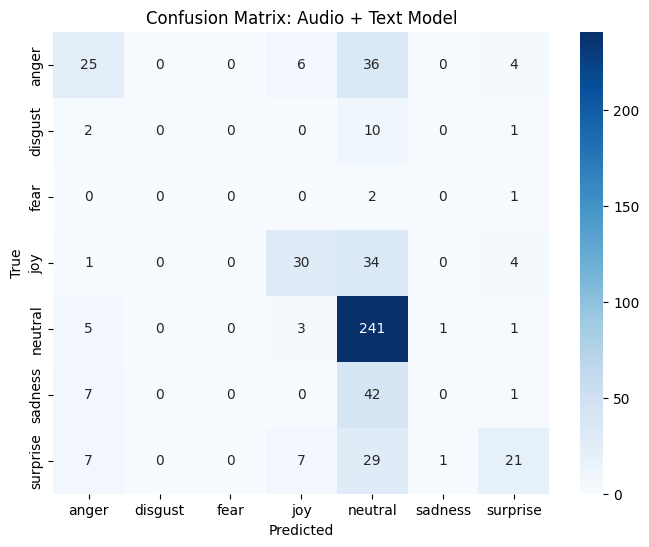

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
labels = np.unique(y_test)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Audio + Text Model')
plt.show()


In [56]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_dict = {label: weight for label, weight in zip(np.unique(y_train), class_weights)}

audio_text_model = RandomForestClassifier(n_estimators=100, class_weight=weights_dict, random_state=42)


In [57]:
audio_text_model.fit(X_train, y_train)


RandomForestClassifier(class_weight={'anger': 1.0886339937434828,
                                     'disgust': 5.423376623376623,
                                     'fear': 6.3465045592705165,
                                     'joy': 0.8957528957528957,
                                     'neutral': 0.29680170575692966,
                                     'sadness': 1.8878842676311032,
                                     'surprise': 1.380952380952381},
                       random_state=42)

              precision    recall  f1-score   support

       anger       0.57      0.30      0.39        71
     disgust       0.00      0.00      0.00        13
        fear       0.00      0.00      0.00         3
         joy       0.72      0.33      0.46        69
     neutral       0.58      0.97      0.72       251
     sadness       0.00      0.00      0.00        50
    surprise       0.70      0.29      0.41        65

    accuracy                           0.59       522
   macro avg       0.37      0.27      0.28       522
weighted avg       0.54      0.59      0.51       522



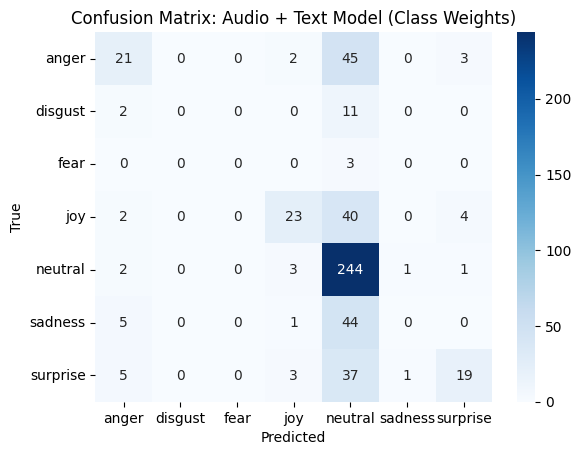

In [58]:
y_pred = audio_text_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=audio_text_model.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=audio_text_model.classes_, yticklabels=audio_text_model.classes_)
plt.title("Confusion Matrix: Audio + Text Model (Class Weights)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [59]:
# Assuming you already have these two arrays
# X_audio = audio MFCC features (e.g., shape: [n_samples, 4000])
# X_text = text BERT embeddings (e.g., shape: [n_samples, 768])

X_audio_text = np.concatenate([X_audio, X_text], axis=1)


In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np
import joblib

# Step 1: Split your features and labels
X_train, X_test, y_train, y_test = train_test_split(X_audio_text, y_audio, test_size=0.2, random_state=42)

# Step 2: Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights_dict = {label: weight for label, weight in zip(np.unique(y_train), class_weights)}

# Step 3: Train Logistic Regression with class weights
logreg = LogisticRegression(max_iter=1000, class_weight=weights_dict, solver='liblinear')
logreg.fit(X_train, y_train)

# Step 4: Evaluate
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

# Optional: Save model
joblib.dump(logreg, "logreg_audio_text_model.joblib")


              precision    recall  f1-score   support

       anger       0.46      0.46      0.46        71
     disgust       0.04      0.08      0.05        13
        fear       0.00      0.00      0.00         3
         joy       0.49      0.57      0.53        69
     neutral       0.77      0.69      0.73       251
     sadness       0.28      0.30      0.29        50
    surprise       0.54      0.48      0.51        65

    accuracy                           0.56       522
   macro avg       0.37      0.37      0.37       522
weighted avg       0.59      0.56      0.58       522



['logreg_audio_text_model.joblib']

In [61]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

import joblib
joblib.dump(mlp_model, "mlp_audio_text_model.joblib")


              precision    recall  f1-score   support

       anger       0.35      0.32      0.34        71
     disgust       0.00      0.00      0.00        13
        fear       0.11      0.33      0.17         3
         joy       0.40      0.49      0.44        69
     neutral       0.70      0.75      0.72       251
     sadness       0.24      0.16      0.19        50
    surprise       0.46      0.37      0.41        65

    accuracy                           0.53       522
   macro avg       0.32      0.35      0.32       522
weighted avg       0.52      0.53      0.52       522



['mlp_audio_text_model.joblib']

In [62]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split first
X_train, X_test, y_train, y_test = train_test_split(X_audio_text, y_audio, test_size=0.2, random_state=42)

# Apply SMOTE only on training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train MLP on balanced data
mlp_model = MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=500, random_state=42)
mlp_model.fit(X_train_smote, y_train_smote)

# Evaluate
y_pred = mlp_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       anger       0.37      0.31      0.34        71
     disgust       0.00      0.00      0.00        13
        fear       0.14      0.33      0.20         3
         joy       0.44      0.49      0.47        69
     neutral       0.69      0.72      0.70       251
     sadness       0.22      0.22      0.22        50
    surprise       0.46      0.40      0.43        65

    accuracy                           0.53       522
   macro avg       0.33      0.35      0.34       522
weighted avg       0.52      0.53      0.52       522



In [63]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y_audio)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_audio_text, y_encoded, test_size=0.2, random_state=42)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

# Predict and decode
y_pred = xgb_model.predict(X_test)
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred)))


              precision    recall  f1-score   support

       anger       0.54      0.42      0.47        71
     disgust       0.00      0.00      0.00        13
        fear       0.00      0.00      0.00         3
         joy       0.54      0.57      0.55        69
     neutral       0.70      0.86      0.77       251
     sadness       0.33      0.18      0.23        50
    surprise       0.62      0.52      0.57        65

    accuracy                           0.63       522
   macro avg       0.39      0.36      0.37       522
weighted avg       0.59      0.63      0.60       522



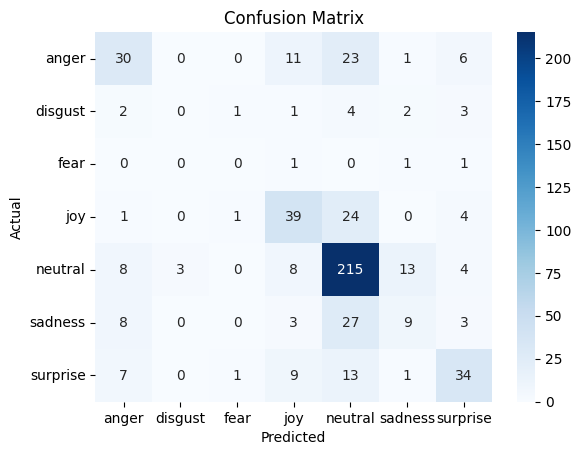

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred), labels=le.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [65]:
pip install transformers torchaudio


Note: you may need to restart the kernel to use updated packages.


In [66]:
import torch
import torch.nn as nn
from transformers import BertModel

class BERTAudioFusionModel(nn.Module):
    def __init__(self, text_hidden=768, audio_input=40, audio_hidden=128, num_classes=7):
        super(BERTAudioFusionModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm_audio = nn.LSTM(audio_input, audio_hidden, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(text_hidden + 2*audio_hidden, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, audio_features):
        # Text encoding from BERT
        text_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_embed = text_output.pooler_output  # shape: [batch, 768]

        # Audio encoding
        _, (h_n, _) = self.lstm_audio(audio_features)  # h_n: [2, batch, hidden]
        audio_embed = torch.cat((h_n[0], h_n[1]), dim=1)  # shape: [batch, 2*hidden]

        # Fuse and classify
        combined = torch.cat((text_embed, audio_embed), dim=1)
        logits = self.classifier(combined)
        return logits


In [67]:
import torch
from torch.utils.data import Dataset

class MultimodalDataset(Dataset):
    def __init__(self, texts, audios, labels, tokenizer, max_len=50):
        self.texts = texts
        self.audios = audios
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        audio = self.audios[idx]  # shape: (seq_len, n_mfcc)
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),     # shape: (max_len,)
            'attention_mask': encoding['attention_mask'].squeeze(0),  # shape: (max_len,)
            'audio': torch.tensor(audio, dtype=torch.float),    # shape: (seq_len, n_mfcc)
            'label': torch.tensor(label, dtype=torch.long)
        }


In [68]:
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from concurrent.futures import ThreadPoolExecutor

# --- 0. Filter train_df to only existing video files
def is_audio_file_present(row, folder):
    fname = f'dia{row["Dialogue_ID"]}_utt{row["Utterance_ID"]}.mp4'
    return os.path.exists(os.path.join(folder, fname))

video_folder = "/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train/train_splits"
train_df = train_df[train_df.apply(is_audio_file_present, axis=1, folder=video_folder)].reset_index(drop=True)

# --- 1. Fast MFCC Extraction (multithreaded)
def process_audio_row(row, folder, sr=16000, n_mfcc=40):
    fname = f'dia{row["Dialogue_ID"]}_utt{row["Utterance_ID"]}.mp4'
    path = os.path.join(folder, fname)
    try:
        audio, _ = librosa.load(path, sr=sr)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc).T
        return mfcc
    except:
        return None

def extract_audio_and_mfcc_fast(df, folder, sr=16000, n_mfcc=40, max_workers=8):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_audio_row, row, folder, sr, n_mfcc) for _, row in df.iterrows()]
        features = [f.result() for f in tqdm(futures, total=len(futures))]
    return features

audio_features = extract_audio_and_mfcc_fast(train_df, video_folder, sr=16000, n_mfcc=40, max_workers=8)

# --- 2. Text + Labels
text_list = train_df['Utterance'].values
le = LabelEncoder()
labels = le.fit_transform(train_df['Emotion'].values)

# --- 3. Keep only valid audio entries
valid_indices = [i for i, feat in enumerate(audio_features) if feat is not None]
text_list = [text_list[i] for i in valid_indices]
labels = [labels[i] for i in valid_indices]
audio_features = [audio_features[i] for i in valid_indices]

# --- 4. Pad/truncate MFCC
def pad_mfcc(features, max_len=300):
    padded = []
    for mfcc in features:
        if mfcc.shape[0] > max_len:
            padded.append(mfcc[:max_len])
        else:
            pad_width = max_len - mfcc.shape[0]
            padded.append(np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant'))
    return np.array(padded)

audio_features = pad_mfcc(audio_features, max_len=300)

# --- 5. Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# --- 6. Split
audio_train, audio_val, text_train, text_val, y_train, y_val = train_test_split(
    audio_features, text_list, labels, test_size=0.2, random_state=42, stratify=labels
)

# --- 7. Dataset & Dataloader
train_dataset = MultimodalDataset(text_train, audio_train, y_train, tokenizer, max_len=50)
val_dataset   = MultimodalDataset(text_val,   audio_val,   y_val,   tokenizer, max_len=50)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


100%|██████████| 9989/9989 [15:04<00:00, 11.04it/s]


In [69]:
# ---------------- IMPORTS ----------------
import os
import torch
import torch.nn as nn
import torchaudio
import pandas as pd
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

# ---------------- CONFIG ----------------
sr = 16000
n_mfcc = 40
video_folder = "/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train/train_splits"
csv_path = "/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train/train_sent_emo.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- STEP 0: Filter missing ----------------
def is_audio_present(row):
    fname = f'dia{row["Dialogue_ID"]}_utt{row["Utterance_ID"]}.mp4'
    return os.path.exists(os.path.join(video_folder, fname))

train_df = pd.read_csv(csv_path)
train_df = train_df[train_df.apply(is_audio_present, axis=1)].reset_index(drop=True)
print(f"✅ Found {len(train_df)} valid audio samples.")

# ---------------- STEP 1: MFCC Extraction ----------------
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sr,
    n_mfcc=n_mfcc,
    melkwargs={'n_fft': 400, 'hop_length': 160, 'n_mels': 64}
)

def extract_single_mfcc(row, target_len=sr*5):
    fname = f'dia{row["Dialogue_ID"]}_utt{row["Utterance_ID"]}.mp4'
    path = os.path.join(video_folder, fname)
    try:
        waveform, sample_rate = torchaudio.load(path)
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        if sample_rate != sr:
            waveform = torchaudio.functional.resample(waveform, sample_rate, sr)
        if waveform.shape[1] < target_len:
            pad_len = target_len - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_len))
        else:
            waveform = waveform[:, :target_len]
        mfcc = mfcc_transform(waveform).squeeze(0)  # (n_mfcc, T)
        return mfcc.numpy()
    except:
        return np.zeros((n_mfcc, 501))  # Assuming fixed length

print("🚀 Extracting MFCC features...")
audio_features = Parallel(n_jobs=-1)(
    delayed(extract_single_mfcc)(row) for _, row in tqdm(train_df.iterrows(), total=len(train_df))
)
audio_features = np.stack(audio_features)
print("✅ MFCC shape:", audio_features.shape)  # (N, 40, T)

# ---------------- STEP 2: Text + Labels ----------------
text_list = train_df['Utterance'].tolist()
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train_df['Emotion'])

# ---------------- STEP 3: Train-Test Split ----------------
X_aud_train, X_aud_val, X_text_train, X_text_val, y_train, y_val = train_test_split(
    audio_features, text_list, labels, test_size=0.2, random_state=42, stratify=labels
)

# ---------------- STEP 4: Cache BERT Embeddings ----------------
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

@torch.no_grad()
def get_bert_embeddings(texts, tokenizer, max_len=50, batch_size=32):
    model = BertModel.from_pretrained('bert-base-uncased').to(device)
    model.eval()
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="🔄 Caching BERT embeddings"):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(batch_texts, padding='max_length', truncation=True,
                            max_length=max_len, return_tensors='pt')
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.pooler_output
        all_embeddings.append(embeddings.cpu())
    return torch.cat(all_embeddings, dim=0)

text_emb_train = get_bert_embeddings(X_text_train, tokenizer)
text_emb_val   = get_bert_embeddings(X_text_val, tokenizer)

# ---------------- STEP 5: Dataset ----------------
class CachedMultimodalDataset(Dataset):
    def __init__(self, text_embeddings, audio_feats, labels):
        self.text_embeddings = text_embeddings
        self.audio_feats = audio_feats
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'text': self.text_embeddings[idx],
            'audio': torch.tensor(self.audio_feats[idx], dtype=torch.float32),  # shape: (40, T)
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = CachedMultimodalDataset(text_emb_train, X_aud_train, y_train)
val_dataset   = CachedMultimodalDataset(text_emb_val,   X_aud_val,   y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

# ---------------- STEP 6: CNN + LSTM Fusion Model ----------------
class CNNLSTMTextAudioFusion(nn.Module):
    def __init__(self, text_dim=768, n_mfcc=40, num_classes=7):
        super().__init__()
        self.text_proj = nn.Sequential(
            nn.Linear(text_dim, 256),
            nn.ReLU()
        )
        self.audio_cnn = nn.Sequential(
            nn.Conv1d(n_mfcc, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)  # (B, 64, T/2)
        )
        self.audio_lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True, bidirectional=True)

        self.classifier = nn.Sequential(
            nn.Linear(256 + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, text_embed, audio_feat):
        # text_embed: (B, 768)
        t_out = self.text_proj(text_embed)  # (B, 256)

        # audio_feat: (B, 40, T)
        a = self.audio_cnn(audio_feat)  # (B, 64, T/2)
        a = a.permute(0, 2, 1)  # (B, T/2, 64)
        self.audio_lstm.flatten_parameters()
        a_out, _ = self.audio_lstm(a)  # (B, T/2, 128)
        a_last = a_out[:, -1, :]  # (B, 128)

        combined = torch.cat([t_out, a_last], dim=1)
        return self.classifier(combined)

# ---------------- Model Setup ----------------
model = CNNLSTMTextAudioFusion(num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ---------------- Training Loop ----------------
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        text = batch['text'].to(device)
        audio = batch['audio'].to(device)
        labels = batch['label'].to(device)

        outputs = model(text, audio)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"📘 Epoch {epoch+1}/{num_epochs} - Loss: {total_loss / len(train_loader):.4f}")

    # --- Validation ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            text = batch['text'].to(device)
            audio = batch['audio'].to(device)
            labels = batch['label'].to(device)

            outputs = model(text, audio)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"✅ Val Accuracy: {correct / total:.4f}")


✅ Found 9989 valid audio samples.
🚀 Extracting MFCC features...


100%|██████████| 9989/9989 [02:11<00:00, 75.74it/s]


✅ MFCC shape: (9989, 40, 501)


🔄 Caching BERT embeddings: 100%|██████████| 63/63 [02:13<00:00,  2.11s/it]


📘 Epoch 1/10 - Loss: 1.5254
✅ Val Accuracy: 0.4760
📘 Epoch 2/10 - Loss: 1.4170
✅ Val Accuracy: 0.5260
📘 Epoch 3/10 - Loss: 1.3405
✅ Val Accuracy: 0.5596
📘 Epoch 4/10 - Loss: 1.3133
✅ Val Accuracy: 0.5546
📘 Epoch 5/10 - Loss: 1.2892
✅ Val Accuracy: 0.5631
📘 Epoch 6/10 - Loss: 1.2715
✅ Val Accuracy: 0.5766
📘 Epoch 7/10 - Loss: 1.2472
✅ Val Accuracy: 0.5811
📘 Epoch 8/10 - Loss: 1.2410
✅ Val Accuracy: 0.5886
📘 Epoch 9/10 - Loss: 1.2218
✅ Val Accuracy: 0.5856
📘 Epoch 10/10 - Loss: 1.2062
✅ Val Accuracy: 0.5976


In [70]:
print("Zaang I miss you")

Zaang I miss you
